<a href="https://colab.research.google.com/github/TheodorIvanov/Summer_Project/blob/master/summer_project_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data

In [20]:
from google.colab import files # insert json token

import json # alternatively can use files.upload()
dict = {"username":"tedbg41","key":"e8b997c78473e26b4bec20ca33c9ca66"}
with open('kaggle.json', 'w') as fp:
    json.dump(dict, fp)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the Zip database from Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzipping the file
import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


## Libraries and Settings


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
sns.set_palette("Set2")
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC

# Supressing  Warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)


## Exploratory Analysis

In [22]:
df = pd.read_csv('creditcard.csv')

In [23]:
# Descriptives and checking for NaNs

print('\n Shape \n =================================== \n',  df.shape)
print('\n Data types \n =================================== \n', df.dtypes)
print('\n Checking for NANs \n =================================== \n', df.isnull().sum())



 Shape 
 (284807, 31)

 Data types 
 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

 Checking for NANs 
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


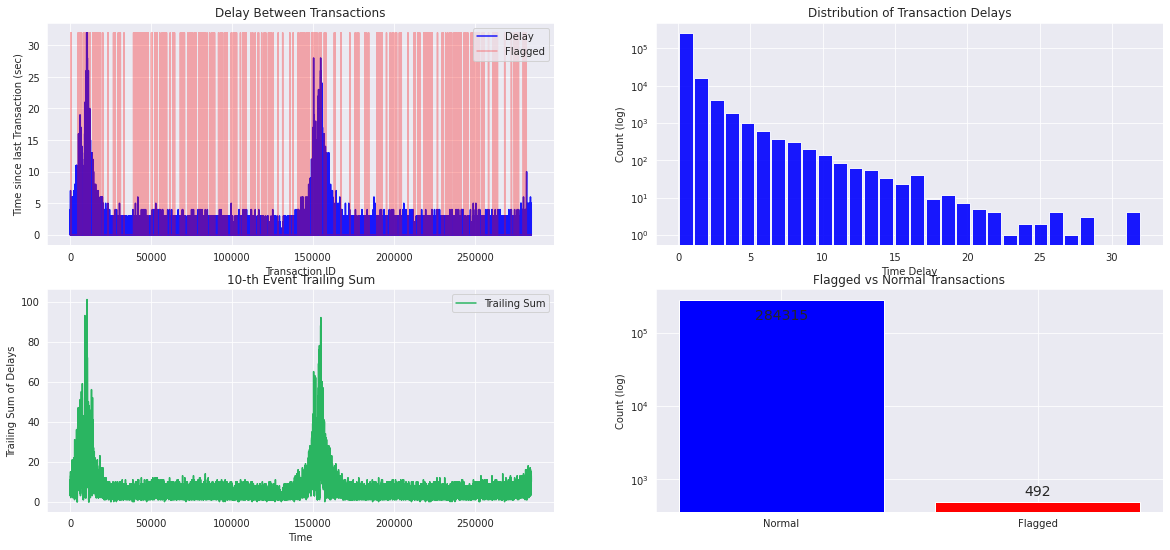

In [24]:
# Differencing with Lag = 1 to measure the time intervals between each transaction

df['difftime'] = np.insert(np.diff(df['Time'], n=1),0,0) 

# Plotting the time intervals and frauds

plt.figure(figsize=(20,9))
plt.subplot(221)
plt.plot(df['difftime'],alpha=0.9, label = 'Delay', color = 'blue')
plt.plot(df['Class']*32, color = 'red', alpha=0.3, label = 'Flagged') # multiply by 32 to fill the yaxis
plt.legend(loc=1)
plt.grid(True)
plt.xlabel('Transaction ID')
plt.ylabel('Time since last Transaction (sec)')
plt.title('Delay Between Transactions')
plt.axis('tight')


plt.subplot(222)
plt.hist(df['difftime'], bins=30, log=True, rwidth=0.9, alpha=0.9, color = 'blue')
plt.title('Distribution of Transaction Delays')
plt.xlabel('Time Delay')
plt.ylabel('Count (log)')
plt.grid(True)


plt.subplot(223)
plt.plot(df['difftime'].rolling(10).sum(), label = 'Trailing Sum', color = '#2ab561')
plt.title('10-th Event Trailing Sum')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Trailing Sum of Delays')
plt.grid(True)


plt.subplot(224)
plt.bar(x=df['Class'].value_counts().index,
        height=df['Class'].value_counts().values,
        color='BrBG',log=True)
plt.text(0,150000, str(df['Class'].value_counts().values[0]),
         fontsize = 14, horizontalalignment='center')
plt.text(1,600, str(df['Class'].value_counts().values[1]),
         fontsize = 14, horizontalalignment='center')
plt.title('Flagged vs Normal Transactions')
plt.ylabel('Count (log)')
plt.grid(True)
plt.xticks([0,1],['Normal', 'Flagged'])

plt.show()


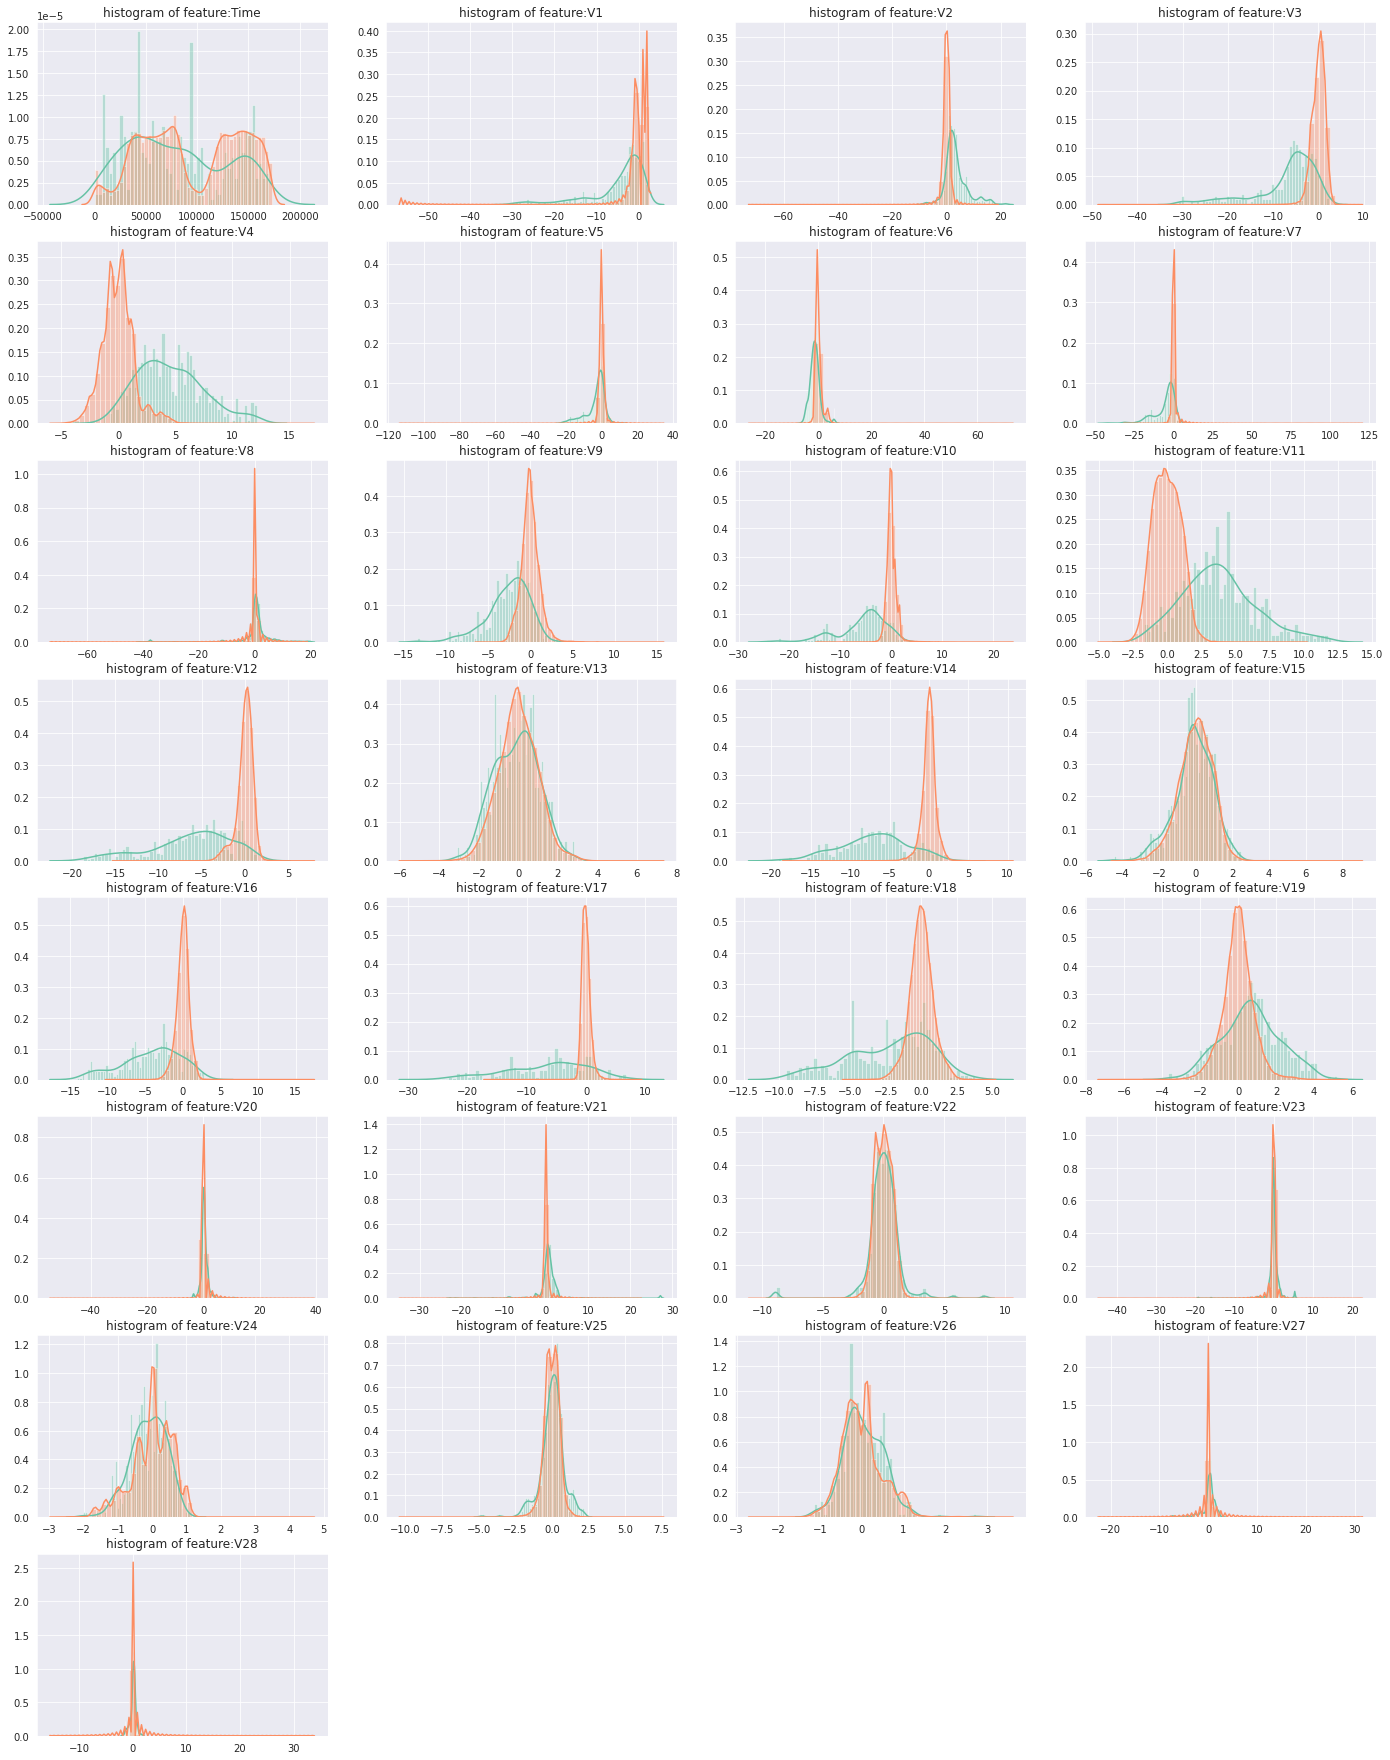

In [25]:
features = df.iloc[:,0:29].columns
plt.figure(figsize=(24,28*4))
gs = gridspec.GridSpec(28, 4)

for i, c in enumerate(df[features]):
 ax = plt.subplot(gs[i])
 sns.distplot(df[c][df.Class == 1], bins=50)
 sns.distplot(df[c][df.Class == 0], bins=50)
 ax.set_xlabel('')
 ax.set_title('histogram of feature:' + str(c))
plt.show()

In [26]:
# Scaling the data

scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Time','Class'], axis=1)), columns=df.drop(['Time','Class'], axis=1).columns) # scaling all columns apart from Time and Class
scaled['Class'] = df['Class']

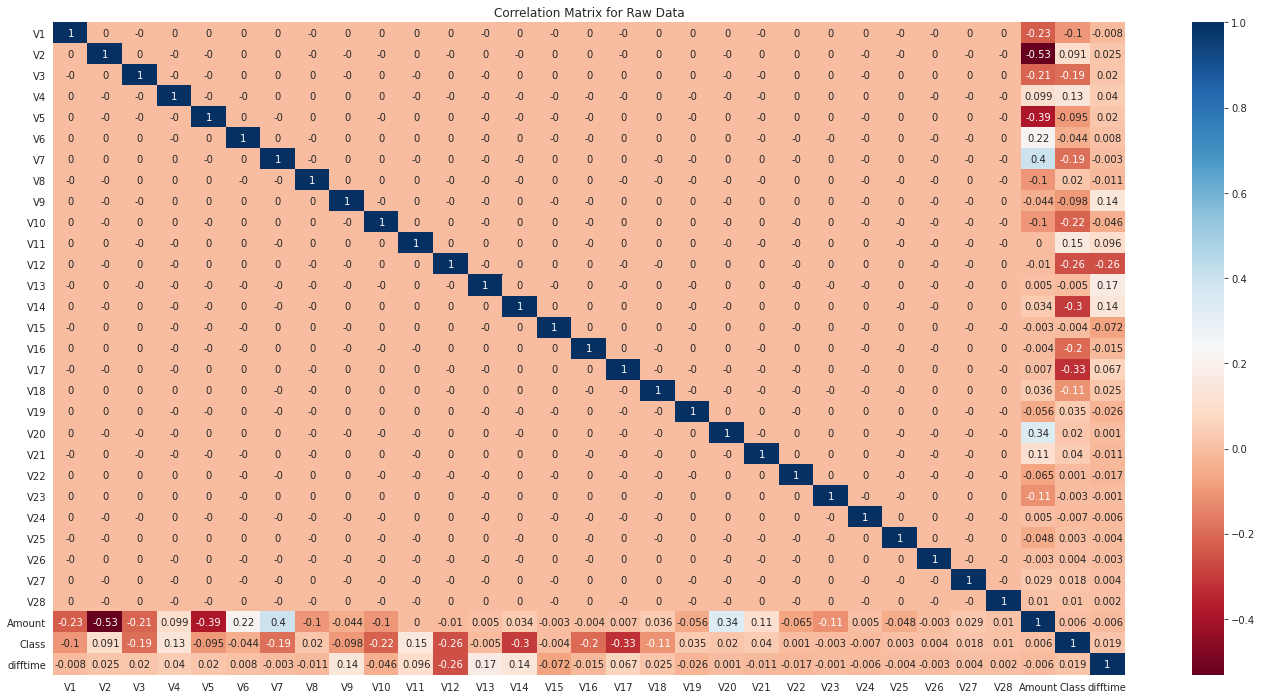

In [27]:
#Plotting the correlation matrix

plt.figure(figsize=(24,12))
sns.heatmap(round(df.loc[:, df.columns != 'Time'].corr(), 3), cmap = 'RdBu', annot=True)
plt.title('Correlation Matrix for Raw Data')
plt.show()

# plt.figure(figsize=(24,12))
# sns.heatmap(round(scaled.corr(), 3), cmap = 'BrBG', annot=True)
# plt.title('Correlation Matrix for Scaled Data')

## Sampling

In [28]:
# Undersampling to account for the uneven balance between Frauds and Cleared transactions

frauds = scaled[scaled.Class == 1]
cleared = scaled[scaled.Class == 0]

cleared_sample = cleared.loc[np.random.choice(cleared.index, size = len(frauds)),:] # selects a random set of cleared transactions equal to the number of frauds 

undersample = [frauds, cleared_sample]
undersample = pd.concat(undersample)


## SVM


In [29]:
# Performance metrics and Grid Search functions

def Model_Performance(model, X_test, y_test, prediction):
  # Performance Metrics
    print('\n Confusion Matrix \n =================================== \n')
    sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap='RdBu', fmt='g', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))

  # Reciever Receiver operating characteristic (ROC) curve
    if model:
      from sklearn.metrics import plot_roc_curve
      svc_disp = plot_roc_curve(model, X_test, y_test)
      plt.show()
    else:
      pass

def SVM_search(X_train, X_test, y_train, y_test, grid_search=True, verbose=0, jobs=1, evaluate=False):
  from sklearn.model_selection import GridSearchCV

  # Supressing the flood of Data Conversion Warnings
  import warnings
  from sklearn.exceptions import DataConversionWarning
  warnings.filterwarnings(action='ignore', category=DataConversionWarning)
  
  if grid_search: # if grid_search parameter is True then

    # SVM Classifiers
    kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

    #A function which returns the corresponding SVC model
    def getClassifier(ktype):
        if ktype == 0:
            # Polynomial kernal
            return SVC(kernel='poly', degree=8, gamma="auto")
        elif ktype == 1:
            # Radial Basis Function kernal
            return SVC(kernel='rbf', gamma="auto")
        elif ktype == 2:
            # Sigmoid kernal
            return SVC(kernel='sigmoid', gamma="auto")
        elif ktype == 3:
            # Linear kernal
            return SVC(kernel='linear', gamma="auto")

    for i in range(4):
      # Train a SVC model using different kernal
      svclassifier = getClassifier(i) 
      svclassifier.fit(X_train, y_train)
      # Make prediction
      y_pred = svclassifier.predict(X_test)
      # Evaluate our model
      if evaluate:
        print("Evaluation:", kernels[i], "kernel")  # Can be uncommented for further details
        print(classification_report(y_test,y_pred))
      else:
        pass

    # Setting the Search Parameters
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
    
    # Performing the Grid Search
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=verbose, n_jobs=jobs)
    model = grid.fit(X_train,y_train)

    # Performance Metrics
    
    print('\n Best Estimator Model \n =================================== \n', grid.best_estimator_)
    grid_predictions = grid.predict(X_test)
    Model_Performance(model = model, X_test = X_test, y_test = y_test, prediction = grid_predictions)

  else:
    # Performing the Standard Model
    model = svm.SVC().fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Performance Metrics
    Model_Performance(model = model, X_test = X_test, y_test=y_test, prediction=prediction)



 Best Estimator Model 
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

 Confusion Matrix 



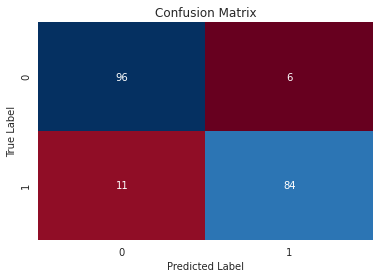


 Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       102
           1       0.93      0.88      0.91        95

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



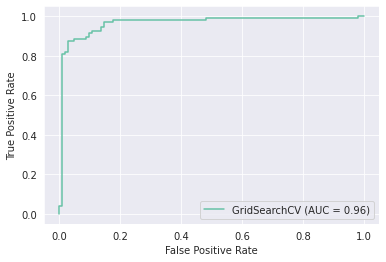


 Confusion Matrix 



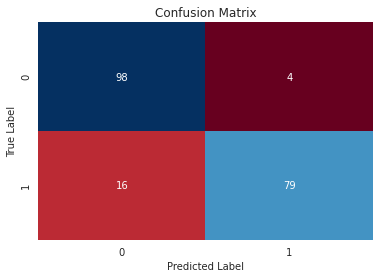


 Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       102
           1       0.95      0.83      0.89        95

    accuracy                           0.90       197
   macro avg       0.91      0.90      0.90       197
weighted avg       0.90      0.90      0.90       197



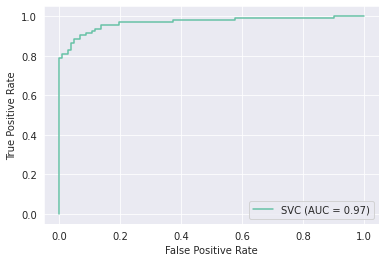

In [30]:
# Splitting into training and validation sets

X = undersample.loc[:, undersample.columns != 'Class']
y = undersample.loc[:, undersample.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 66)

# SVM for Undersampled data

SVM_search(X_train, X_test, y_train, y_test,grid_search=True, jobs =-1)
SVM_search(X_train, X_test, y_train, y_test,grid_search=False)



 Confusion Matrix 



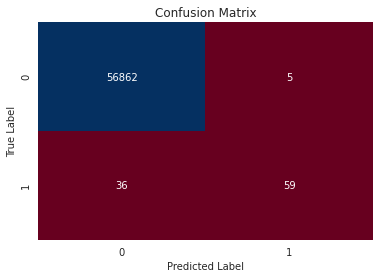


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.92      0.62      0.74        95

    accuracy                           1.00     56962
   macro avg       0.96      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962



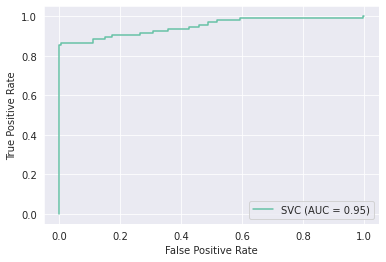

In [31]:
# SVM for Normal Data

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 66)

SVM_search(X_train, X_test, y_train, y_test, grid_search=False, jobs=-1, verbose=2)



 Confusion Matrix 



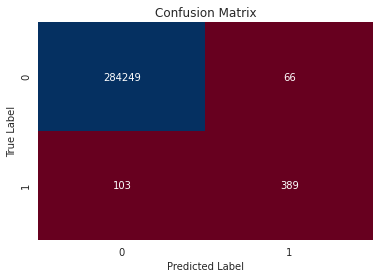


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.85      0.79      0.82       492

    accuracy                           1.00    284807
   macro avg       0.93      0.90      0.91    284807
weighted avg       1.00      1.00      1.00    284807



In [32]:
# Manual Model for the Full Scaled data using the Best of the Undersampled models

X = undersample.loc[:, undersample.columns != 'Class']
y = undersample.loc[:, undersample.columns == 'Class']

X_train, _ , y_train, _  = train_test_split(X,y, train_size = 0.8, random_state = 66)

model = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=66, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

prediction = model.predict(X)

# Performance Metrics
Model_Performance(False, False, y, prediction)


 Confusion Matrix 



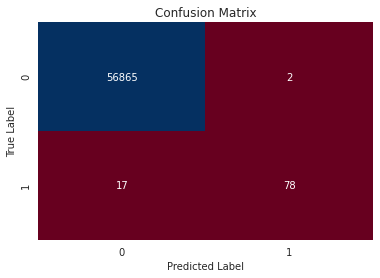


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.97      0.82      0.89        95

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



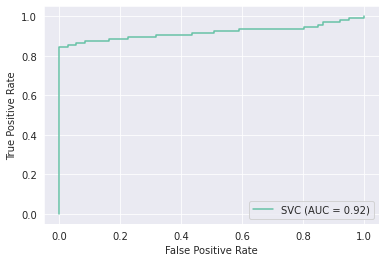

In [33]:
# Model using Selected features

fs = scaled.iloc[:, [2, 3, 8, 9, 10, 11, 13, 15, 16, 17, -1]] # selecting the features which show different distributions between cleared and flagged transactions

X = fs.loc[:, fs.columns != 'Class']
y = fs.loc[:, fs.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 66)

model = svm.SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=66, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

prediction = model.predict(X_test)

# Performance Metrics
Model_Performance(model, X_test, y_test, prediction)

## Autoencoders

In [61]:
import tensorflow as tf
import keras
import keras.layers as layers

from keras import losses
from keras import optimizers
# from keras.layers import Dense, Input
# from keras.layers import Conv2D, Flatten
# from keras.layers import Reshape, Conv2DTranspose
# from keras.models import Model
# from keras.datasets import mnist
# from keras.utils import plot_model
# from keras import backend as K


In [35]:
# Reloading the Data

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 66)

In [36]:
input_shape = X.shape[1]
X.shape

(284807, 30)

In [45]:
# Using only the cleared transactions to train the Autoencoder

frauds = scaled[scaled.Class == 1]
cleared = scaled[scaled.Class == 0]

cleared = cleared.drop('Class', axis = 1)

X_train, X_test, _ , _ = train_test_split(cleared, cleared, train_size = 0.8, random_state = 66)

input_dim = X_train.shape[1]

Input shape: (None, 30)
Input type: <dtype: 'float32'>
Model: "basic_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 119       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                128       
_________________________________________________________________
dense_23 (Dense)             (None, 30)                510       
Total params: 1,253
Trainable params: 1,253
Non-trainable params: 0
_________________________________________________________________


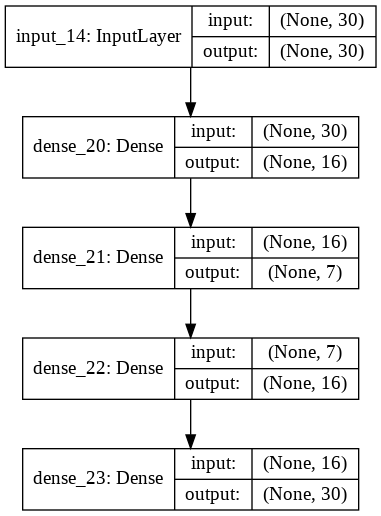

In [62]:
# Defining the graph of the model

inputs = keras.Input(shape=(input_dim,))

print("Input shape: {}".format(inputs.shape))
print("Input type: {}".format(inputs.dtype))

graph = layers.Dense(16, activation='relu')(inputs)
graph = layers.Dense(7, activation='relu')(graph)
graph = layers.Dense(16, activation='relu')(graph)
outputs = layers.Dense(input_dim, activation='relu')(graph)

model = keras.Model(inputs, outputs, name = 'basic_autoencoder')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [66]:
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae','accuracy'])

batch_size = 512
epochs = 10

history = model.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split= 0.2)

Train on 181961 samples, validate on 45491 samples
Epoch 1/10
181961/181961 [==============================] - 2s 12us/step - loss: 0.6293 - mae: 0.5126 - accuracy: 0.5501 - val_loss: 0.6157 - val_mae: 0.5126 - val_accuracy: 0.5501
Epoch 2/10
181961/181961 [==============================] - 2s 11us/step - loss: 0.6290 - mae: 0.5124 - accuracy: 0.5503 - val_loss: 0.6153 - val_mae: 0.5123 - val_accuracy: 0.5522
Epoch 3/10
181961/181961 [==============================] - 2s 11us/step - loss: 0.6288 - mae: 0.5123 - accuracy: 0.5518 - val_loss: 0.6155 - val_mae: 0.5127 - val_accuracy: 0.5543
Epoch 4/10
181961/181961 [==============================] - 2s 11us/step - loss: 0.6285 - mae: 0.5122 - accuracy: 0.5517 - val_loss: 0.6152 - val_mae: 0.5124 - val_accuracy: 0.5519
Epoch 5/10
181961/181961 [==============================] - 2s 11us/step - loss: 0.6284 - mae: 0.5121 - accuracy: 0.5525 - val_loss: 0.6156 - val_mae: 0.5129 - val_accuracy: 0.5553
Epoch 6/10
181961/181961 [==================

In [37]:
# import time
# for i in range(60):
#   time.sleep(60)
#   print(i)

KeyboardInterrupt: ignored

In [ ]:
# Redundant Code

# Benford's Law
# ============================================
# !pip install benfordslaw
# import benfordslaw as bl
# X = df[df.Class == 0]['Amount']
# out = bl.fit(X)
# bl.plot(out, title='Count')

In [ ]:
# # Defining a function for SVM Classification with reports

# from sklearn import svm
# from sklearn.metrics import confusion_matrix, classification_report

# def SVM_Model(X_train, X_test, y_train, y_test):
#     '''
#     Defines a function for creating SVM Models for Classification and provides Metrics.

#     Parameters
#     --------------
#     X_train : training data
#     X_test : validation data
#     y_train : training labels
#     y_test : validation labels

#     '''
#     model = svm.SVC().fit(X_train, y_train) # SVC = Support Vector Classifier
#     prediction = model.predict(X_test)
#     print('\n Confusion Matrix: \n =================================== \n')
#     sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap='RdBu', fmt='g', cbar=False)
#     plt.title('Confusion Matrix')
#     plt.xlabel('True Label')
#     plt.ylabel('Predicted Label')
#     plt.show()

#     print('\n Classification Report: \n =================================== \n', classification_report(y_test,prediction))